In [1]:
%load_ext autoreload
%autoreload 2
from animalclef.spark import get_spark
from pyspark.sql import functions as F, Window
from pathlib import Path
import numpy as np
from animalclef.dataset import split_reid_data, summarize_split
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
spark = get_spark(cores=4, memory="2g")
display(spark)

root = Path.home() / "scratch/animalclef"
metadata = spark.read.csv(f"{root}/raw/metadata.csv", header=True, inferSchema=True)
embeddings = spark.read.parquet(f"{root}/processed/embeddings.parquet")
embeddings = embeddings.select(
    "image_id",
    F.array(
        *[F.col(c).cast("float") for c in embeddings.columns if c.startswith("embed_")]
    ).alias("embeddings"),
)
df = metadata.join(embeddings, on="image_id", how="inner").select(
    "image_id",
    "identity",
    "dataset",
    "embeddings",
    F.count("image_id").over(Window.partitionBy("identity")).alias("identity_count"),
)
df.printSchema()
pdf = df.toPandas()

25/05/09 05:24:38 WARN Utils: Your hostname, hawksbill-vm resolves to a loopback address: 127.0.1.1; using 192.168.10.12 instead (on interface ens18)
25/05/09 05:24:38 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/09 05:24:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/05/09 05:24:39 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


root
 |-- image_id: integer (nullable = true)
 |-- identity: string (nullable = true)
 |-- dataset: string (nullable = true)
 |-- embeddings: array (nullable = false)
 |    |-- element: float (containsNull = true)
 |-- identity_count: long (nullable = false)



25/05/09 05:24:42 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


25/05/09 05:24:50 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [3]:
cond = (~pdf.identity.isnull()) & (pdf.identity_count > 2)
train_df, val_df, test_df = split_reid_data(pdf[cond])
summarize_split(train_df, val_df, test_df)

,Split,Num Individuals,Num Images,Train Image Overlap,Val Image Overlap,Test Image Overlap,Train Image %,Val Image %,Test Image %,Known Individuals,Unknown Individuals
0,Train,404,3686,3686,0,0,100.0,0.0,0.0,404,0
1,Validation,458,2857,0,2857,0,0.0,100.0,0.0,404,54
2,Test,620,5992,0,0,5992,0.0,0.0,100.0,404,216


### k-nn model

In [4]:
import faiss
from animalclef.metrics import BAKS, BAUS

X_train = np.stack(train_df.embeddings.values)
X_val = np.stack(val_df.embeddings.values)
X_test = np.stack(test_df.embeddings.values)

# Create a FAISS index for efficient nearest neighbor search
index = faiss.IndexFlatL2(X_train.shape[1])
index.add(X_train)  # Add training embeddings to the index

# Perform a search for the validation set
# use the nearest neighbor for now for voting
k = 1
# Distances and indices for validation set
dist_val, idx_val = index.search(X_val, k)
display(dist_val)
# Calculate the accuracy for validation and test sets
# do the actual prediction

# identities in val not in train
predictions_val = train_df.iloc[idx_val.flatten()]["identity"].values
identity_val_only = sorted(
    set(val_df.identity.unique()) - set(train_df.identity.unique())
)

display(
    BAKS(val_df["identity"].values, predictions_val, identity_val_only),
    BAUS(val_df["identity"].values, predictions_val, identity_val_only, "unknown"),
)

array([[162.5907 ],
       [338.1266 ],
       [258.65796],
       ...,
       [281.3036 ],
       [266.28088],
       [260.57837]], shape=(2857, 1), dtype=float32)

np.float64(0.3059503773077349)

np.float64(0.0)

In [5]:
# let's find the min/average distance to every other individual in test set.
# let's create a function to cache the distances
from functools import lru_cache
from tqdm import tqdm


def get_min_distance_to_neighbor(train_df):
    @lru_cache(maxsize=16)
    def get_index(individual):
        """get all embeddings that do not belong to an individual. This will form
        the minimum intercluster distance."""
        sub = train_df[train_df.identity != individual]
        # Use the dimension of the embedding vectors
        embedding_dim = len(
            sub.embeddings.iloc[0]
        )  # Get dimension from first embedding
        index = faiss.IndexFlatL2(embedding_dim)
        index.add(np.stack(sub.embeddings.values))
        return index

    distances = []
    # order the training set by identity so that our lru cache is more efficient
    train_df = train_df.sort_values(by="identity")
    for row in tqdm(train_df.itertuples(), total=len(train_df)):
        # get the index for the individual
        index = get_index(row.identity)
        # search for the nearest neighbor in the training set
        dist, _ = index.search(np.array([row.embeddings]), 1)
        # get the distance to the nearest neighbors
        distances.append(dist[0][0])
    return np.array(distances)


# get stats on the distances
distances = get_min_distance_to_neighbor(train_df)
print(f"Min distance: {distances.min()}")
print(f"Max distance: {distances.max()}")
print(f"Mean distance: {distances.mean()}")
print(f"Std distance: {distances.std()}")
# IQR
q1 = np.percentile(distances, 25)
q2 = np.percentile(distances, 50)
q3 = np.percentile(distances, 75)
iqr = q3 - q1
print(f"IQR: {iqr}")
print(f"Q1: {q1}")
print(f"Q3: {q3}")
# MAD
print(f"Median: {q2}")
mad = np.median(np.abs(distances - np.median(distances)))
print(f"MAD: {mad}")

  0%|          | 0/3686 [00:00<?, ?it/s]

100%|██████████| 3686/3686 [00:06<00:00, 540.72it/s] 

Min distance: 48.666786193847656
Max distance: 713.1578369140625
Mean distance: 262.1321105957031
Std distance: 88.09282684326172
IQR: 114.24188232421875
Q1: 200.41943359375
Q3: 314.66131591796875
Median: 260.2188720703125
MAD: 57.146087646484375


In [6]:
# now let's figure out a good threshold on the validation set


def make_prediction(train_df, other_df, threshold, new_label="new_individual"):
    # Create a FAISS index for efficient nearest neighbor search
    X_train = np.stack(train_df.embeddings.values)
    X_other = np.stack(other_df.embeddings.values)

    index = faiss.IndexFlatL2(X_train.shape[1])
    index.add(X_train)

    dist, idx = index.search(X_other, 1)
    predictions = train_df.iloc[idx.flatten()]["identity"].values
    # if the distance is above a threshold, it's unknown
    for i, v in enumerate(dist.flatten()):
        if v > threshold:
            predictions[i] = new_label
    return predictions


def search_threshold(train_df, other_df, thresholds):
    identity_other_only = sorted(
        set(other_df.identity.unique()) - set(train_df.identity.unique())
    )

    scores = []
    for threshold in tqdm(thresholds):
        predictions = make_prediction(train_df, other_df, threshold)
        baks = BAKS(val_df["identity"].values, predictions, identity_other_only)
        baus = BAUS(
            val_df["identity"].values,
            predictions,
            identity_other_only,
            "new_individual",
        )
        # geometric average
        score = np.sqrt(baks * baus)
        scores.append(
            {
                "threshold": threshold,
                "baks": baks,
                "baus": baus,
                "score": score,
            }
        )
    return pd.DataFrame(scores)


base_threshold_df = search_threshold(train_df, val_df, np.linspace(10, 1000, 20))
display(base_threshold_df)

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:04<00:00,  4.68it/s]


,threshold,baks,baus,score
0,10.000000,0.000955,1.000000,0.030909
1,62.105263,0.037600,1.000000,0.193908
2,114.210526,0.075027,0.879490,0.256876
3,166.315789,0.134280,0.708275,0.308394
4,218.421053,0.190853,0.630024,0.346760
5,270.526316,0.248835,0.447165,0.333572
6,322.631579,0.277239,0.242024,0.259034
7,374.736842,0.294824,0.126842,0.193380
8,426.842105,0.296936,0.059246,0.132636
9,478.947368,0.301707,0.029243,0.093930


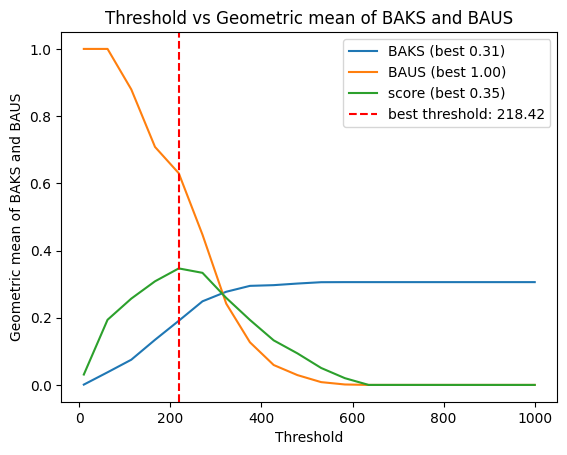

In [7]:
def plot_threshold_score(df, col="threshold"):
    best_score = df["score"].max()
    best_threshold = df[col][df["score"].idxmax()]

    # plot baus and baks
    plt.plot(
        df[col],
        df["baks"],
        label=f"BAKS (best {df['baks'].max():.2f})",
    )
    plt.plot(
        df[col],
        df["baus"],
        label=f"BAUS (best {df['baus'].max():.2f})",
    )
    plt.plot(
        df[col],
        df["score"],
        label=f"score (best {best_score:.2f})",
    )
    # line at the best threshold
    plt.axvline(
        best_threshold,
        color="red",
        linestyle="--",
        label=f"best threshold: {best_threshold:.2f}",
    )
    plt.xlabel("Threshold")
    plt.ylabel("Geometric mean of BAKS and BAUS")
    plt.title("Threshold vs Geometric mean of BAKS and BAUS")
    plt.legend()
    plt.show()


plot_threshold_score(base_threshold_df)

{'initial_threshold': np.float32(260.21887), 'mad': np.float32(57.146088)}

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:21<00:00,  4.67it/s]


,threshold,baks,baus,score,k
0,88.780609,0.056885,0.962145,0.233947,-3.000000
1,92.244008,0.059227,0.953298,0.237615,-2.939394
2,95.707408,0.059759,0.943007,0.237388,-2.878788
3,99.170807,0.064184,0.930309,0.244358,-2.818182
4,102.634206,0.067726,0.918740,0.249444,-2.757576
...,...,...,...,...,...
95,417.803538,0.296818,0.062531,0.136236,2.757576
96,421.266937,0.296818,0.060304,0.133788,2.818182
97,424.730337,0.296818,0.059246,0.132609,2.878788
98,428.193736,0.297126,0.059246,0.132678,2.939394


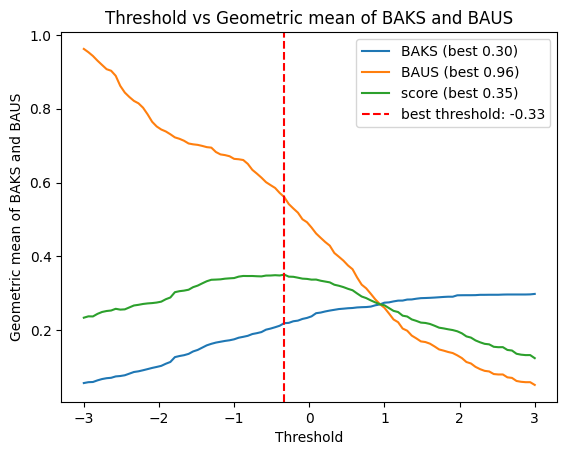

In [8]:
initial_threshold = np.median(distances)
mad = np.median(np.abs(distances - initial_threshold))
display(
    {
        "initial_threshold": initial_threshold,
        "mad": mad,
    }
)
k = np.linspace(-3, 3, 100)
mad_threshold_df = search_threshold(
    train_df, val_df, initial_threshold + (np.linspace(-3, 3, 100) * mad)
)
# add k as a column
mad_threshold_df["k"] = k
display(mad_threshold_df)
plot_threshold_score(mad_threshold_df, col="k")

In [9]:
# at the highest score, get the value of k
# this basically runs the test against our best validation hyperparameters
best_k = mad_threshold_df["k"][mad_threshold_df["score"].idxmax()]
threshold = initial_threshold + (mad * best_k)
display(
    {
        "best_k": best_k,
        "mad": mad,
        "threshold": threshold,
        "val_baks": mad_threshold_df["baks"].max(),
        "val_baus": mad_threshold_df["baus"].max(),
        "val_score": mad_threshold_df["score"].max(),
    }
)
identity_other_only = sorted(
    set(test_df.identity.unique()) - set(train_df.identity.unique())
)
predictions = make_prediction(train_df, test_df, threshold)
baks = BAKS(test_df["identity"].values, predictions, identity_other_only)
baus = BAUS(
    test_df["identity"].values, predictions, identity_other_only, "new_individual"
)
# geometric average
score = np.sqrt(baks * baus)
display(
    {
        "test_baks": baks,
        "test_baus": baus,
        "test_score": score,
    }
)

{'best_k': np.float64(-0.33333333333333304),
 'mad': np.float32(57.146088),
 'threshold': np.float64(241.17017618815106),
 'val_baks': np.float64(0.2983637447843002),
 'val_baus': np.float64(0.9621452621452611),
 'val_score': np.float64(0.35061186821092616)}

{'test_baks': np.float64(0.21656801290599506),
 'test_baus': np.float64(0.5753651536076155),
 'test_score': np.float64(0.3529953087679125)}

In [10]:
# retune on the test set to get a new best threshold and see if
# this improves the score
new_train_df = pd.concat([train_df, val_df])
distances = get_min_distance_to_neighbor(new_train_df)
mad = np.median(np.abs(distances - np.median(distances)))
initial_threshold = np.median(distances)
new_threshold_df = search_threshold(
    new_train_df, test_df, initial_threshold + (np.linspace(-3, 3, 100) * mad)
)

  0%|          | 0/6543 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:50<00:00,  1.97it/s]


In [12]:
best_k = mad_threshold_df["k"][mad_threshold_df["score"].idxmax()]
threshold = initial_threshold + (mad * best_k)
display(
    {
        "initial_threshold": initial_threshold,
        "mad": mad,
        "best_k": best_k,
        "threshold": threshold,
    }
)
identity_other_only = sorted(
    set(test_df.identity.unique()) - set(new_train_df.identity.unique())
)
predictions = make_prediction(new_train_df, test_df, threshold)
baks = BAKS(test_df["identity"].values, predictions, identity_other_only)
baus = BAUS(
    test_df["identity"].values, predictions, identity_other_only, "new_individual"
)
# geometric average
score = np.sqrt(baks * baus)
display(
    {
        "test_baks": baks,
        "test_baus": baus,
        "test_score": score,
    }
)
# this is the best score we can get with this method

{'initial_threshold': np.float32(245.99341),
 'mad': np.float32(53.382065),
 'best_k': np.float64(-0.33333333333333304),
 'threshold': np.float64(228.1993865966797)}

{'test_baks': np.float64(0.25336139841740896),
 'test_baus': np.float64(0.5720431097743044),
 'test_score': np.float64(0.3807015133243643)}

Looks like the score increases if we include more items in the training dataset. This intuitively makes sense because we have more distances to look at.

# final prediction

In [ ]:
# now for the final prediction
known_df = pdf[pdf.identity.notnull()]
unknown_df = pdf[pdf.identity.isnull()]

distances = get_min_distance_to_neighbor(known_df)
mad = np.median(np.abs(distances - np.median(distances)))
initial_threshold = np.median(distances)
best_k = mad_threshold_df["k"][mad_threshold_df["score"].idxmax()]
display(
    {
        "initial_threshold": initial_threshold,
        "mad": mad,
        "best_k": best_k,
        "threshold": initial_threshold + (mad * best_k),
    }
)

predictions = make_prediction(known_df, unknown_df, initial_threshold + (mad * best_k))
# count how many are predicted as "unknown"
display(
    {
        "unknown": len(predictions[predictions == "new_individual"]),
        "known": len(predictions[predictions != "new_individual"]),
        "total": len(predictions),
    }
)

  0%|          | 7/13074 [00:00<03:46, 57.77it/s]

100%|██████████| 13074/13074 [01:05<00:00, 200.71it/s]


{'initial_threshold': np.float32(225.73389),
 'mad': np.float32(54.902695),
 'best_k': -0.33333333333333304,
 'threshold': np.float32(207.43298)}

{'unknown': 712, 'known': 1423, 'total': 2135}

In [14]:
# save this result
unknown_df["identity"] = predictions
output_path = Path.home() / "shared/animalclef/data/predictions/20250509-triplet-v1.csv"
output_path.parent.mkdir(parents=True, exist_ok=True)
unknown_df[["image_id", "identity"]].to_csv(output_path, index=False, header=True)

/tmp/ipykernel_324821/1740131179.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_df["identity"] = predictions


In [15]:
! kaggle competitions submit -c animal-clef-2025 -f {output_path} -m "triplet-v1"

100%|██████████████████████████████████████| 48.9k/48.9k [00:00<00:00, 78.5kB/s]
Successfully submitted to AnimalCLEF25 @ CVPR-FGVC & LifeCLEF